In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
# some constants and cutoffs
mincutOffLosVel = 50.
maxcutOffLosVel = 2000.
mincutOffspWdth = 100.
maxcutOffspWdth = 500.
minCutOffPwr = 3.
gridSizenormMLT = 0.5
gridSizeMLAT = 0.25
minNumPntsCutoffCell = 5 # Somewhat arbitrary determination!!

In [3]:
inpCols = [ "beam", "range", "geoAzm", "magAzm", "vLos"\
           , "MLAT", "MLT", "MLON", "GLAT", "GLON", "radId"\
           , "radCode","normMLT", "normMLTRound", "spwdth", "pwr" ]
velsDataDF = pandas.read_csv("../data/apr9-840-losVels.txt")
velsDataDF.columns = inpCols
velsDataDF = velsDataDF[ (abs(velsDataDF["vLos"]) >= mincutOffLosVel) &\
                       (velsDataDF["spwdth"] >= mincutOffspWdth)&\
                       (velsDataDF["pwr"] >= minCutOffPwr)&\
                       (abs(velsDataDF["vLos"]) <= maxcutOffLosVel)&\
                       (velsDataDF["spwdth"] <= maxcutOffspWdth)].reset_index(drop=True)
velsDataDF.head()

,beam,range,geoAzm,magAzm,vLos,MLAT,MLT,MLON,GLAT,GLON,radId,radCode,normMLT,normMLTRound,spwdth,pwr
0,5,27,-41.65,-38.83,-378.1679,56.7707,2.5717,-18.7139,45.3710,-89.3080,33,bks,2.5717,2,108.6326,12.8346
1,5,28,-41.65,-39.16,-396.3842,57.0027,2.5290,-19.3536,45.6378,-89.7470,33,bks,2.5290,2,108.6326,9.4804
2,5,29,-41.65,-39.50,-379.2044,57.2309,2.4859,-20.0005,45.9024,-90.1899,33,bks,2.4859,2,108.6326,8.7086
3,5,30,-41.65,-39.85,-368.0763,57.4553,2.4423,-20.6546,46.1649,-90.6368,33,bks,2.4423,2,101.2517,7.1071
4,6,25,-37.79,-33.55,-221.1927,56.8363,2.7261,-16.3974,45.3789,-87.7046,33,bks,2.7261,2,102.3670,14.6025


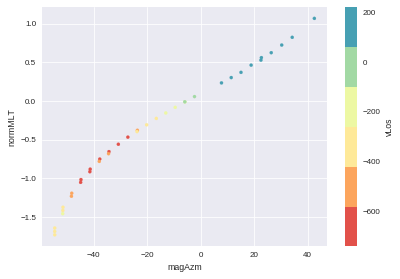

In [66]:
selLat = 59.5
selMLT = -1.5
delLat = 0.25
delMLT = 1.5
fig1 = plt.figure()
ax = fig1.add_subplot(111)
selDF = velsDataDF[ (velsDataDF["MLAT"] >= (selLat - delLat) ) &\
          (velsDataDF["MLAT"] < (selLat + delLat) )]
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Spectral"))
selDF.plot( kind='scatter',
              x='magAzm',
              y='normMLT',
              c='vLos',
              s=10., cmap=seaMap, ax=ax)
fig1.savefig("../figs/test2.pdf",bbox_inches='tight')

In [94]:
# divide azims into categories of 5 deg each
selDF["rndAzim"] = selDF["magAzm"].round()
# get MLTs to nearest half
selDF["normMLTRound"] = [ round(x * 2) / 2 for x in selDF["normMLT"] ]
mltAzmDF = selDF.groupby(["normMLTRound"])\
            ["rndAzim"].aggregate(\
                lambda x: tuple(x)).reset_index()
# Loop through each MLT to find if it has good enough data
# for fitting a sine curve!!

for currMLT in mltAzmDF["normMLTRound"].sort_values().values:
    currAzimVals = list( set( mltAzmDF[ \
            mltAzmDF["normMLTRound"] == currMLT ]\
                        ["rndAzim"].values[0] ) )
    # check azim range!
    currCellAzimRange = max(currAzimVals)\
    - min(currAzimVals)
    print currMLT, currCellAzimRange,currAzimVals

-1.5 4.0 [-55.0, -52.0, -51.0]
-1.0 10.0 [-48.0, -38.0, -45.0, -41.0]
-0.5 14.0 [-24.0, -31.0, -20.0, -27.0, -34.0]
0.0 25.0 [8.0, -17.0, -13.0, -10.0, -6.0, -2.0]
0.5 19.0 [11.0, 15.0, 19.0, 23.0, 26.0, 30.0]
1.0 9.0 [34.0, 43.0]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [78]:
# divide azims into categories of 5 deg each
selDF["rndAzim"] = selDF["magAzm"].round()#( int( round(selDF["magAzm"])/5 ) ) * 5
selDF["normMLTRound"] = [ round(x * 2) / 2 for x in selDF["normMLT"] ]
mltAzmDF = selDF.groupby(["normMLTRound"])["rndAzim"].aggregate(lambda x: tuple(x)).reset_index()
# #selDF[ ["magAzm", "catAzim", "vLos", "MLAT", "normMLT", "normMLTRound"] ]
print list( mltAzmDF[ mltAzmDF["normMLTRound"] == -1. ]["rndAzim"].values[0] )
# print selDF[ ["magAzm", "rndAzim", "vLos", "MLAT", "normMLT", "normMLTRound"] ]

[-41.0, -41.0, -38.0, -38.0, -48.0, -48.0, -45.0, -45.0]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# divide azims into categories of 5 deg each
minAzim = ( int( round(selDF["magAzm"].min())/5 ) -1 ) * 5
maxAzim = ( int( round(selDF["magAzm"].max())/5 ) +1 ) * 5
azimBins = [ i for i in range(minAzim, maxAzim+1, 5) ]
selDF["catAzim"] = pandas.cut( selDF["magAzm"], bins=azimBins )

mltAzmDF = selDF.groupby(["normMLTRound"])["catAzim"].aggregate(lambda x: tuple(x)).reset_index()
#selDF[ ["magAzm", "catAzim", "vLos", "MLAT", "normMLT", "normMLTRound"] ]
print mltAzmDF[ mltAzmDF["normMLTRound"] == 1 ]["catAzim"].unique().tolist()
